# Convolutional Network Benchmark

To obtain a benchmark for a basic convolutional network, we will create a simple network that informs us what to expect when using these networks. This will not contain any novel specializations, it is done to find a baseline which we can improve upon.

The architecture used here is inspired by the research in the form of the paper ['A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification'](https://arxiv.org/pdf/1510.03820.pdf), and is not complex.

While previous experiments have been done to find applicability of convolutional networks, this is the first to run it over a large set of data.

In [1]:
from exp8_feature_extraction import get_balanced_dataset
from scripts.cross_validate import run_cross_validate
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Concatenate, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.models import Model
from keras import regularizers

import matplotlib.pyplot as plt
import numpy as np
import gensim
from seaborn import boxplot
from pandas import DataFrame

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
CROSS_FOLD_NUM = 0 # Change this to whichever fold you wish to run
max_review_words = 218

In [3]:
def _decode_record(record):
    example = tf.parse_single_example(record, {
        'feature': tf.FixedLenFeature([300*max_review_words], tf.float32),
        'reviewer': tf.FixedLenFeature([5], tf.float32),
        'label': tf.FixedLenFeature([2], tf.int64),
    })
    example['feature'] = tf.reshape(example['feature'], [max_review_words, 300, 1])
    return (example['feature'], example['reviewer']), example['label']

In [4]:
filenames = ['TEST-225-' + str(i) + '.tfrecord' for i in range(2)]
train_filenames = [x for i, x in enumerate(filenames) if i != CROSS_FOLD_NUM]

epochs = 12
steps = 293

In [5]:
train_dataset = tf.data.TFRecordDataset(train_filenames).map(_decode_record).repeat(epochs).batch(46)
validation_dataset = tf.data.TFRecordDataset(filenames[CROSS_FOLD_NUM]).map(_decode_record).repeat(epochs).batch(46)

In [6]:
def get_conv_wv_model():
  i1 = Input(shape=(max_review_words, 300, 1))
  i2 = Input(shape=(5,))

  l1 = Conv2D(
          filters=50,
          kernel_size=(10, 300),
          data_format="channels_last",
          activation=relu)(i1)
  l2 = tf.keras.layers.GlobalMaxPooling2D(data_format="channels_last")(l1)
  l3 = Dropout(0.5)(l2)
  l4 = Flatten()(l3)
  l5 = Concatenate(axis=1)([l4, i2])
  l6 = Dense(8, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(l5)
  l8 = Dense(8, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))(l6)
  l9 = Dense(2, activation='softmax')(l8)
  model = Model(inputs=[i1, i2], outputs=l9)
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

In [ ]:
conv_model = get_conv_wv_model()
history = conv_model.fit(train_dataset, steps_per_epoch=9*steps, epochs=epochs, validation_data=validation_dataset, validation_steps=steps)

In [11]:
conv_wv_scores = {
    "loss": [0.5714481531963413, 0.5705330361685248, 0.5726435979885452, 0.5717445115587411,
                0.5776157323207465, 0.5763675441310674, 0.5784062919152881, 0.5681992454943804,
                0.5710791625057065, 0.5722369383829853],
    "accuracies": [0.7098976151935069, 0.711233122967209, 0.7064104499263568, 0.7056685010727762,
               0.705742698073794, 0.7009200229986536, 0.706039476109853, 0.7114557111222589,
               0.7096008357334462, 0.709452444782843],
    "f1": [0.7098975576231504, 0.7112330631591354, 0.7064103907285697, 0.7056684424852755,
              0.7057426380622915, 0.7009199638008664, 0.7060394177257812, 0.7114556513141853,
              0.7096007765356591, 0.7094523859919135]
}

In [ ]:
print("Validation Loss:")
val_loss = history.history['val_loss']
print(val_loss)
print("Validation Accuracy:")
val_accuracy = history.history['val_acc']
print(val_accuracy)
print("Validation F1:")
val_f1 = history.history['val_f1']
print(val_f1)

min_val_loss = 1
best = None
for loss, accuracy, f1 in zip(val_loss, val_accuracy, val_f1):
    if loss < min_val_loss:
        min_val_loss = loss
        best = { 'val_loss': loss, 'val_accuracy': accuracy, 'val_f1': f1 }
print("best:", best)

In [12]:
print(conv_wv_scores)
print("Average accuracy:", sum(conv_wv_scores['accuracies'])/len(conv_wv_scores['accuracies']))

{'loss': [0.5714481531963413, 0.5705330361685248, 0.5726435979885452, 0.5717445115587411, 0.5776157323207465, 0.5763675441310674, 0.5784062919152881, 0.5681992454943804, 0.5710791625057065, 0.5722369383829853], 'accuracies': [0.7098976151935069, 0.711233122967209, 0.7064104499263568, 0.7056685010727762, 0.705742698073794, 0.7009200229986536, 0.706039476109853, 0.7114557111222589, 0.7096008357334462, 0.709452444782843], 'f1': [0.7098975576231504, 0.7112330631591354, 0.7064103907285697, 0.7056684424852755, 0.7057426380622915, 0.7009199638008664, 0.7060394177257812, 0.7114556513141853, 0.7096007765356591, 0.7094523859919135]}
Average accuracy: 0.7076420877980698


Convolutional networks perform significantly better than FFNNs and the results are not widely varying. This appears to be a confident benchmark for a simple convolutional network.

The distribution of results is as follows:

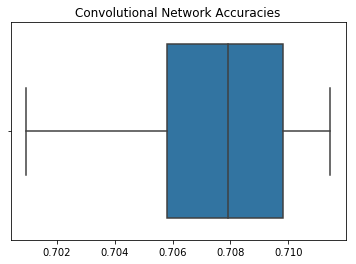

In [13]:
boxplot(DataFrame(conv_wv_scores['accuracies'])).set_title("Convolutional Network Accuracies")

plt.show()

Now let's try the model on unseen data:

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
conv_model = get_conv_wv_model()
conv_model.fit(training_vectors, to_categorical(training_labels), epochs=12, batch_size=128, validation_split=0.3,
               callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 81186 samples, validate on 34794 samples
Epoch 1/12
81186/81186 [==============================] - 137s 2ms/step - loss: 0.6485 - acc: 0.6256 - val_loss: 0.6260 - val_acc: 0.6526
Epoch 2/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.6242 - acc: 0.6541 - val_loss: 0.6272 - val_acc: 0.6517
Epoch 3/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.6081 - acc: 0.6727 - val_loss: 0.6189 - val_acc: 0.6581
Epoch 4/12
81186/81186 [==============================] - 135s 2ms/step - loss: 0.5940 - acc: 0.6828 - val_loss: 0.6121 - val_acc: 0.6670
Epoch 5/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.5795 - acc: 0.6974 - val_loss: 0.6121 - val_acc: 0.6675
Epoch 6/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.5644 - acc: 0.7110 - val_loss: 0.6200 - val_acc: 0.6597
Epoch 7/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.5502 - acc: 0.7193 - val_loss: 0.6173 - 

In [34]:
categorical_labels = to_categorical(held_labels)

In [35]:
conv_model.evaluate(held_vectors, categorical_labels)[1]

10000/10000 [==============================] - 6s 609us/step


0.6657

The model performs very similarly on the unseen data as the data used to create the model. There was not a lot of tweaking, so it is not unreasonable that this should occur. If this can be maintained then this model could do well with slight changes in the domain, something very easy to do with product and service reviews.